In [1]:
%load_ext lab_black

In [2]:
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/inv")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from dataclasses import dataclass, field
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from icecream import ic
import matplotlib_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable
from models.my_efficientnet import EfficientNet
from models.my_essential_inversors import (
    essential_regressor,
    essential_regressor_2,
    essential_regressor_3,
    linear_regressor,
)
from models.my_mobilenet import MobileNet
from models.my_shufflenet import ShuffleNet
from models.my_squeezenet import SqueezeNet
from models.preprocessing import CloudsLayer, ConditionalNoiseLayer

import include.callbacks as callbacks
import include.generators as generators
import include.loss as loss
import include.optimisers as optimisers
import models.seg as sm
from Data import Data_train
from models.preprocessing import CloudsLayer
from saver import Saver
import logging
import sys
from model_training import Trainer

import hydra
import wandb
from omegaconf import DictConfig, OmegaConf

from include.callbacks import initiate_wb
from model_training import Model_training_manager

from typing import List, Optional

matplotlib_functions.setMatplotlibParam()
plt.viridis()
import joblib
import pickle
from include.generators import Generator
from saver import Saver
from include.callbacks import get_modelcheckpoint, ExtraValidation

import model_eval
from Data import Data_train, Data_eval
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger
import models.reg as rm

import hydra
from hydra import initialize, compose
from omegaconf import OmegaConf

2023-12-05 17:36:29.470326: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 17:36:29.470364: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 17:36:29.470388: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 17:36:29.477267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
wandb: ERROR Unable to patch Tensorflow/Ke

<Figure size 1920x1440 with 0 Axes>

In [3]:
# Compose the configuration
cfg = compose(
    config_name="config",
    overrides=["training.max_epochs=10", "+experiment=inv_lip"],
)

# Print the configuration
print(OmegaConf.to_yaml(cfg))

data:
  init:
    _target_: Data.Data_train
    path_train_ds: ${data.path.directory}/${data.path.train.name}/${data.path.train.nc}
    path_valid_ds: ${data.path.directory}/${data.path.valid.name}/${data.path.valid.nc}
    path_extra_valid_ds: ${data.path.directory}/${data.path.extra_valid.name}/${data.path.extra_valid.nc}
  input:
    dir_seg_models: /cerea_raid/users/dumontj/dev/coco2/dl/res/models
    chan_0: xco2
    chan_1: v_wind
    chan_2: u_wind
    chan_3: no2
    chan_4: None
    clouds: true
    path_clouds_array: /libre/dumontj/coco2/dl-input/clouds/extracted_clouds.npy
  output:
    N_emissions: 1
  path:
    directory: /libre/dumontj/coco2/dl-input
    train:
      name: 2km_forLip_2
      nc: train_dataset.nc
    valid:
      name: 2km_forLip_2
      nc: valid_dataset.nc
    extra_valid:
      name: 2km_Lip
      nc: valid_dataset.nc
dir_res: /libre/dumontj/coco2/weights/new/
exp_name: inv_lip
seed: 42
sweep: true
model:
  type: inversion
  name: essential
  loss_func:

In [4]:
initiate_wb(cfg)

wandb: Currently logged in as: joffreydumont (cerea-daml). Use `wandb login --relogin` to force relogin


In [5]:
model_trainer = Model_training_manager(cfg)

/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc


2023-12-05 17:36:46.207420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14628 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5
2023-12-05 17:36:50.052734: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
ic| self.train.shape: (25152, 64, 64, 4)
2023-12-05 17:36:56.210863: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3296722944 exceeds 10% of free system memory.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [ ]:
cbs = callbacks.get_modelcheckpoint(cfg.callbacks.model_checkpoint, [])
cbs = callbacks.get_lrscheduler(cfg.callbacks.learning_rate_monitor, [])
cbs = callbacks.get_wandb(cfg.callbacks.wandb, cbs)

history = callbacks.ExtraValidation(
    (model_trainer.data.x.extra_valid, model_trainer.data.y.extra_valid)
)
cbs.append(WandbMetricsLogger())
cbs.append(history)

In [8]:
data = model_trainer.data

In [10]:
num_examples = 5
example_indices = np.random.choice(data.x.valid.shape[0], num_examples, replace=False)

ic| np.sum(data.x.valid[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 1123
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(data.x.valid[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 879
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(data.x.valid[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 318
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(data.x.valid[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -0.8569037
ic| np.sum(data.x.valid[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 26
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257


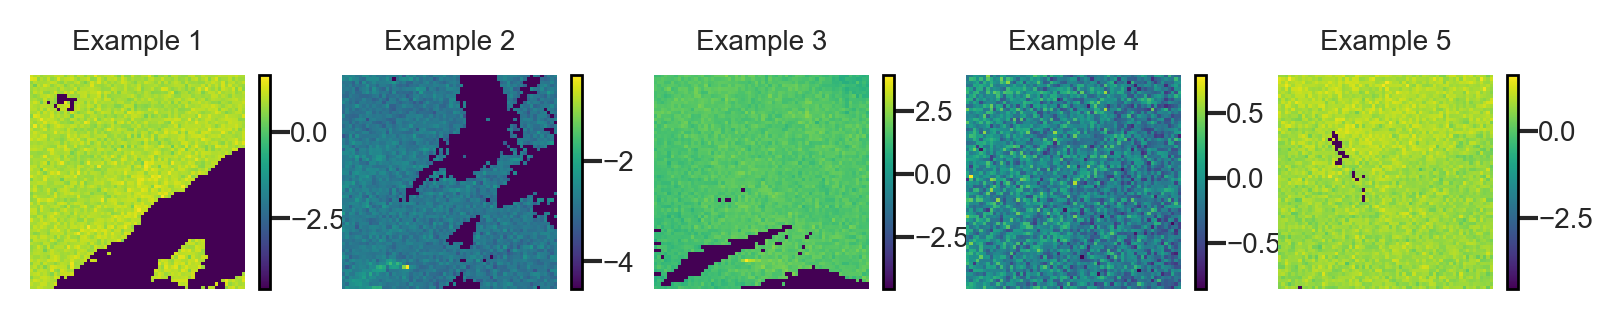

In [11]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(data.x.valid[idx, :, :, 0], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(data.x.valid[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])))
    plt.colorbar(im, cax=cax)
    ic(np.min(data.x.valid[idx, :, :, 0]))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

ic| np.sum(data.x.valid[idx, :, :, 1] == np.median(data.x.valid[:, :, :, 1])): 0
ic| np.sum(data.x.valid[idx, :, :, 1] == np.median(data.x.valid[:, :, :, 1])): 0
ic| np.sum(data.x.valid[idx, :, :, 1] == np.median(data.x.valid[:, :, :, 1])): 0
ic| np.sum(data.x.valid[idx, :, :, 1] == np.median(data.x.valid[:, :, :, 1])): 0
ic| np.sum(data.x.valid[idx, :, :, 1] == np.median(data.x.valid[:, :, :, 1])): 0


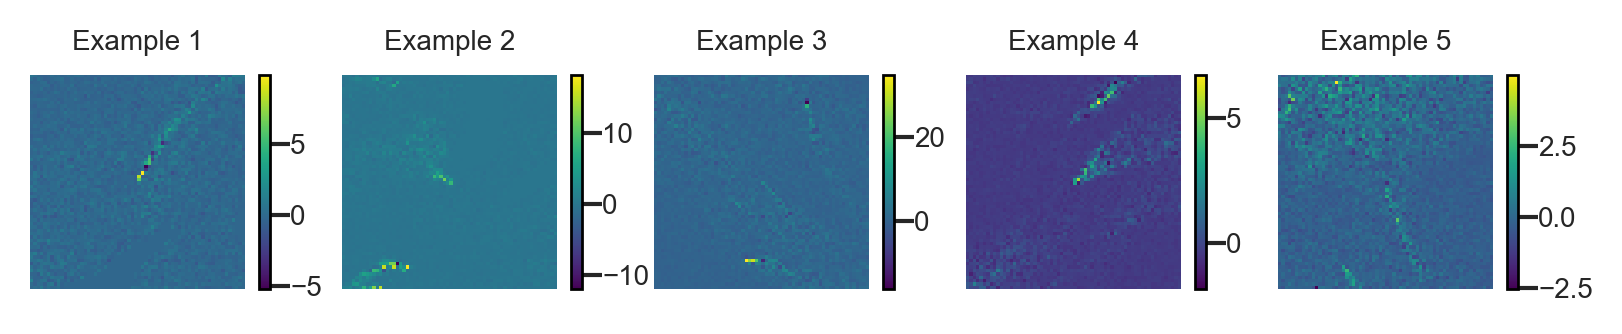

ic| np.median(data.x.valid[:, :, :, 1]): -0.10553343


-0.10553343

In [13]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(data.x.valid[idx, :, :, 3], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(data.x.valid[idx, :, :, 1] == np.median(data.x.valid[:, :, :, 1])))
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()
ic(np.median(data.x.valid[:, :, :, 1]))

In [9]:
from models.preprocessing import (
    ConditionalNoiseLayer,
    CloudsLayer,
    TrainingTimeNormalization,
)

In [10]:
tf.keras.models.load_model(
    "w_best.h5",
    custom_objects={
        "ConditionalNoiseLayer": ConditionalNoiseLayer(
            model_trainer.data.x.xco2_noisy_chans
        ),
        "CloudsLayer": CloudsLayer(
            model_trainer.data.x.clouds_training, model_trainer.data.x.cloudy_chans
        ),
        "TrainingTimeNormalization": TrainingTimeNormalization(
            axis=-1, name="preproc_norm"
        ),
    },
    compile=False,
)

wandb: Waiting for W&B process to finish... (success).


In [16]:
x_batch, y_batch = model_trainer.trainer.generator.__getitem__(0)

In [22]:
plot_data = x_batch

In [23]:
num_examples = 5
example_indices = np.random.choice(plot_data.shape[0], num_examples, replace=False)

ic| np.sum(plot_data[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257


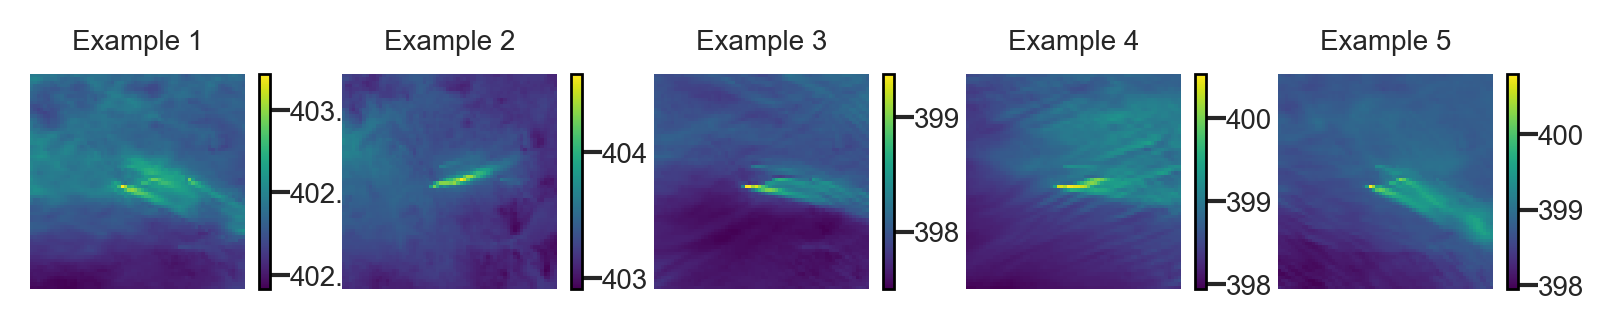

In [24]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data[idx, :, :, 0], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])))
    plt.colorbar(im, cax=cax)
    ic(np.min(data.x.valid[idx, :, :, 0]))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

ic| np.sum(plot_data[idx, :, :, 3] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 3] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 3] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 3] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 3] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257


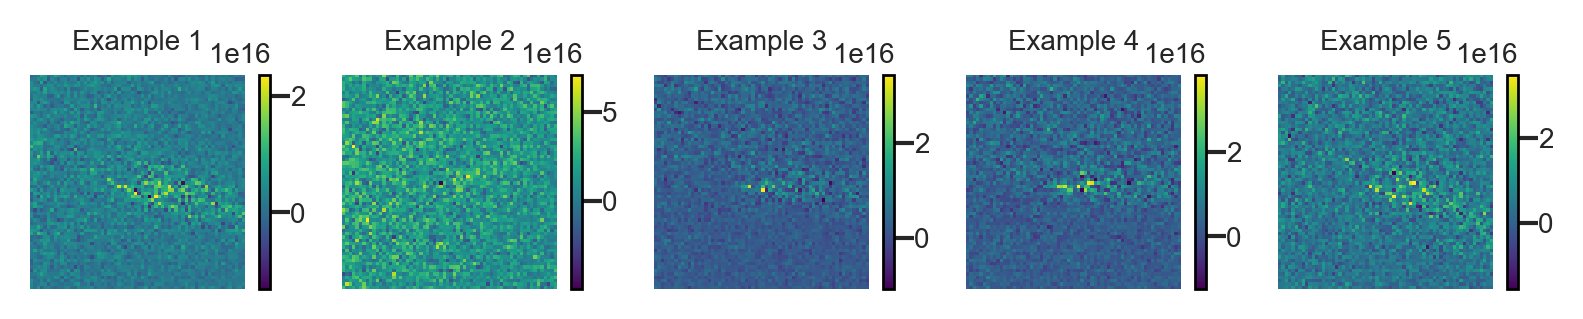

In [25]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data[idx, :, :, 3], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data[idx, :, :, 3] == np.min(data.x.valid[:, :, :, 0])))
    plt.colorbar(im, cax=cax)
    ic(np.min(data.x.valid[idx, :, :, 0]))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [38]:
@dataclass
class Reg_model_builder:
    """Return appropriate regression model."""

    name: str = "linear"
    input_shape: list = field(default_factory=lambda: [64, 64, 3])
    classes: int = 1
    norm_layer: tf.keras.layers.Normalization = tf.keras.layers.Normalization(axis=-1)
    noise_layer: ConditionalNoiseLayer = ConditionalNoiseLayer([])
    dropout_rate: float = 0.2
    scaling_coefficient: float = 1
    cloud_layer: CloudsLayer = CloudsLayer(np.zeros((1)), [])
    cloud_bool: bool = True

    def get_model(self):
        """Return regression model, keras or locals."""

        self.bottom_layers = rm.get_preprocessing_layers(
            self.noise_layer,
            self.norm_layer,
            self.cloud_layer,
            self.cloud_bool,
        )

        inputs = tf.keras.layers.Input(self.input_shape, name="input_layer")
        outputs = self.bottom_layers(inputs)

        model = tf.keras.Model(inputs, outputs)

        return model

In [39]:
reg_builder = Reg_model_builder(
    cfg.model.name,
    model_trainer.data.x.fields_input_shape,
    model_trainer.data.y.classes,
    model_trainer.data.x.norm_layer,
    model_trainer.data.x.noise_layer,
    cfg.model.dropout_rate,
    cfg.model.scaling_coefficient,
    model_trainer.data.x.cloud_layer,
    model_trainer.data.x.cloud_bool,
)
model = reg_builder.get_model()

In [38]:
model.compile(optimizer='adam', loss='mean_squared_error')  # Replace with appropriate optimizer and loss

NameError: name 'model' is not defined

In [66]:
x_batch_preproc = model(x_batch, training=True)

In [67]:
plot_data = x_batch_preproc

ic| np.sum(plot_data[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 1578
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 1947
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 95
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 1107
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 1874
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257


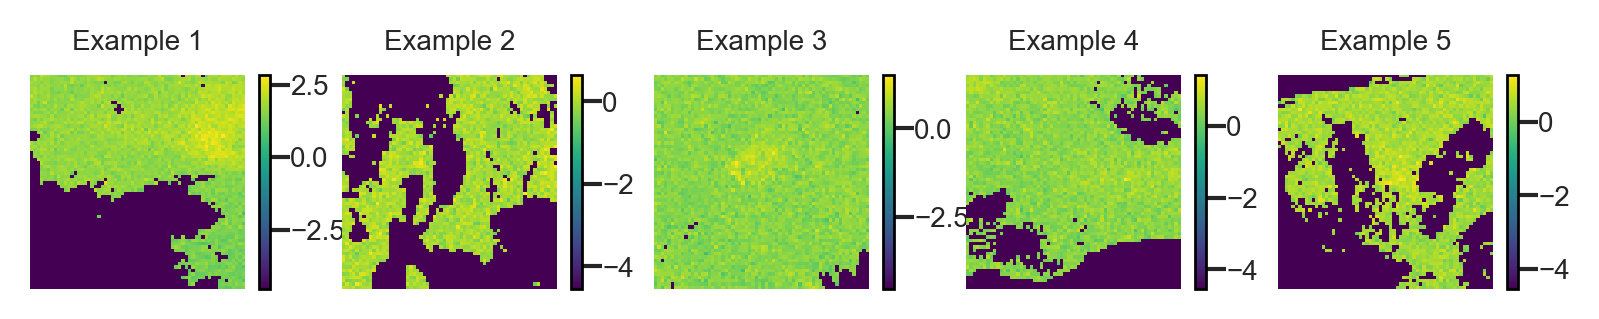

In [68]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data[idx, :, :, 0], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])))
    plt.colorbar(im, cax=cax)
    ic(np.min(data.x.valid[idx, :, :, 0]))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

ic| np.sum(plot_data[idx, :, :, 3] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 3] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 3] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 3] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 3] == np.min(data.x.valid[:, :, :, 0])): 0
ic| np.min(data.x.valid[idx, :, :, 0]): -4.5498257


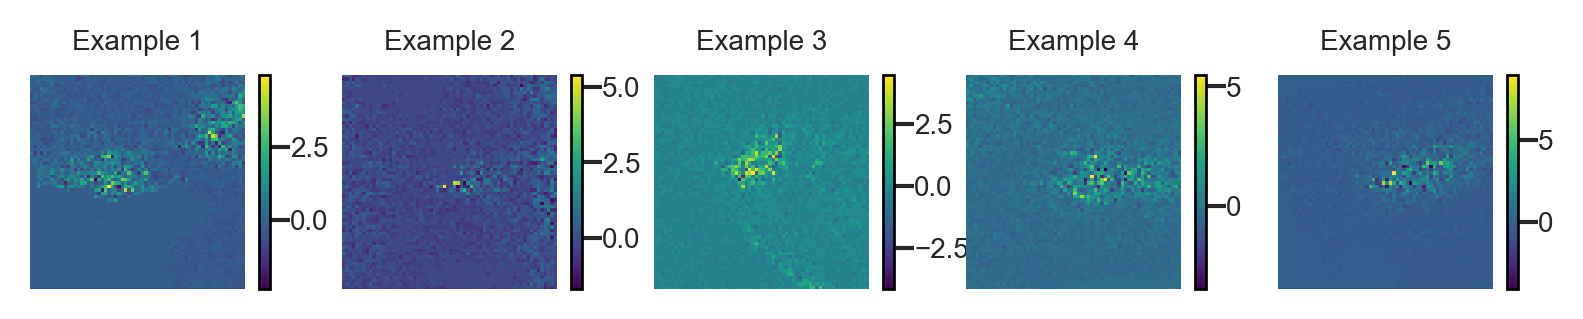

In [69]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data[idx, :, :, 3], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data[idx, :, :, 3] == np.min(data.x.valid[:, :, :, 0])))
    plt.colorbar(im, cax=cax)
    ic(np.min(data.x.valid[idx, :, :, 0]))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [7]:
model_trainer.run()

Epoch 1/10
786/786 [==============================] - ETA: 0s - loss: 10.0933 - mean_absolute_percentage_error: 79.0022 - mean_absolute_error: 10.0933
Epoch 1: val_loss did not improve from 4.25631
extra_val_loss: [3.155747175216675, 21.533781051635742, 3.155747175216675]
786/786 [==============================] - 14s 17ms/step - loss: 10.0933 - mean_absolute_percentage_error: 79.0022 - mean_absolute_error: 10.0933 - val_loss: 8.4829 - val_mean_absolute_percentage_error: 70.2306 - val_mean_absolute_error: 8.4829 - lr: 0.0010
Epoch 2/10
783/786 [============================>.] - ETA: 0s - loss: 10.0995 - mean_absolute_percentage_error: 79.8182 - mean_absolute_error: 10.0995
Epoch 2: val_loss did not improve from 4.25631
extra_val_loss: [3.346691608428955, 23.731220245361328, 3.346691608428955]
786/786 [==============================] - 14s 17ms/step - loss: 10.0923 - mean_absolute_percentage_error: 79.8111 - mean_absolute_error: 10.0923 - val_loss: 7.0291 - val_mean_absolute_percentage_


KeyboardInterrupt



In [ ]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

In [7]:
model_trainer.model.fit(
    model_trainer.data.x.valid,
    model_trainer.data.y.valid,
    epochs=model_trainer.trainer.N_epochs,
    validation_data=(model_trainer.data.x.valid, model_trainer.data.y.valid),
    verbose=1,
    steps_per_epoch=int(
        np.floor(model_trainer.data.x.train.shape[0] / model_trainer.trainer.batch_size)
    ),
    callbacks=cbs,
    shuffle=True,
)

Epoch 1/10


2023-11-30 17:46:38.781858: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-30 17:46:39.591217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 17:46:40.153172: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-30 17:46:40.591178: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9fdea31ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 17:46:40.591211: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-11-30 17:46:40.595754: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set 

784/786 [============================>.] - ETA: 0s - loss: 6.7582 - mean_absolute_percentage_error: 44.9220 - mean_absolute_error: 6.7582
Epoch 1: val_loss improved from inf to 6.68239, saving model to w_best.h5
786/786 [==============================] - 17s 15ms/step - loss: 6.7499 - mean_absolute_percentage_error: 44.8930 - mean_absolute_error: 6.7499 - val_loss: 6.6824 - val_mean_absolute_percentage_error: 38.9107 - val_mean_absolute_error: 6.6824
Epoch 2/10
  6/786 [..............................] - ETA: 8s - loss: 4.7448 - mean_absolute_percentage_error: 34.8063 - mean_absolute_error: 4.7448

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


786/786 [==============================] - ETA: 0s - loss: 6.6960 - mean_absolute_percentage_error: 43.7422 - mean_absolute_error: 6.6960
Epoch 2: val_loss improved from 6.68239 to 6.58887, saving model to w_best.h5
786/786 [==============================] - 11s 15ms/step - loss: 6.6960 - mean_absolute_percentage_error: 43.7422 - mean_absolute_error: 6.6960 - val_loss: 6.5889 - val_mean_absolute_percentage_error: 42.6524 - val_mean_absolute_error: 6.5889
Epoch 3/10
783/786 [============================>.] - ETA: 0s - loss: 6.6597 - mean_absolute_percentage_error: 43.1684 - mean_absolute_error: 6.6597
Epoch 3: val_loss did not improve from 6.58887
786/786 [==============================] - 11s 14ms/step - loss: 6.6590 - mean_absolute_percentage_error: 43.2214 - mean_absolute_error: 6.6590 - val_loss: 8.7439 - val_mean_absolute_percentage_error: 65.0473 - val_mean_absolute_error: 8.7439
Epoch 4/10
785/786 [============================>.] - ETA: 0s - loss: 6.6523 - mean_absolute_percentag

In [6]:
model_trainer.model.fit(
    model_trainer.data.x.valid,
    model_trainer.data.y.valid,
    epochs=10,
    validation_data=(model_trainer.data.x.valid, model_trainer.data.y.valid),
    verbose=1,
    steps_per_epoch=int(np.floor(model_trainer.data.x.train.shape[0] / 32)),
    # callbacks=model_trainer.callbacks,
    shuffle=True,
)

Epoch 1/10


2023-11-30 16:18:39.988428: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-30 16:18:40.789816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 16:18:41.363087: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-30 16:18:41.801527: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5252c29940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 16:18:41.801561: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-11-30 16:18:41.806679: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set 

786/786 [==============================] - 15s 13ms/step - loss: 6.7975 - mean_absolute_percentage_error: 45.6349 - mean_absolute_error: 6.7975 - val_loss: 6.6088 - val_mean_absolute_percentage_error: 43.4113 - val_mean_absolute_error: 6.6088
Epoch 2/10
415/786 [==============>...............] - ETA: 4s - loss: 6.6588 - mean_absolute_percentage_error: 43.7831 - mean_absolute_error: 6.6588


KeyboardInterrupt



In [7]:
model_trainer.model.fit(
    model_trainer.data.x.valid,
    model_trainer.data.y.valid,
            epochs=model_trainer.trainer.N_epochs,
            validation_data=(model_trainer.data.x.valid, model_trainer.data.y.valid),
            verbose=1,
            steps_per_epoch=int(np.floor(model_trainer.data.x.train.shape[0] / model_trainer.trainer.batch_size)),
            shuffle=True,
        )

Epoch 1/10


2023-11-30 16:26:12.436294: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-30 16:26:13.218389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 16:26:13.791636: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-30 16:26:14.225503: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f79798e5140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 16:26:14.225542: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-11-30 16:26:14.230457: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set 

 14/786 [..............................] - ETA: 9s - loss: 10.9198 - mean_absolute_percentage_error: 77.9749 - mean_absolute_error: 10.9198   


KeyboardInterrupt



In [ ]:
model_trainer.model.fit(
            self.generator,
            epochs=self.N_epochs,
            validation_data=(data.x.valid, data.y.valid),
            verbose=1,
            steps_per_epoch=int(np.floor(data.x.train.shape[0] / self.batch_size)),
            callbacks=self.callbacks,
            shuffle=True,
        )

In [ ]:
model_trainer.trainer.train_model(model_trainer.model, model_trainer.data)

Epoch 1/10


2023-11-30 16:17:08.733095: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


784/786 [============================>.] - ETA: 0s - loss: 13.4298 - mean_absolute_percentage_error: 93.9304 - mean_absolute_error: 13.4298
Epoch 1: val_loss improved from inf to 8.58729, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
val_loss = model_trainer.run()


Epoch 1/10


2023-11-30 15:50:24.340512: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-30 15:50:25.158206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 15:50:25.737040: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-30 15:50:26.213004: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd1c0324160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 15:50:26.213060: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-11-30 15:50:26.224928: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set 

785/786 [============================>.] - ETA: 0s - loss: 12.2787 - mean_absolute_percentage_error: 89.4288 - mean_absolute_error: 12.2787
Epoch 1: val_loss improved from inf to 6.49113, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
reg_builder = rm.Reg_model_builder(
    "essential",
    data.x.fields_input_shape,
    data.y.classes,
    data.x.norm_layer,
    data.x.noise_layer,
    cloud_layer=data.x.cloud_layer,
)
model = reg_builder.get_model()
model.compile(
    "adam", "MeanAbsoluteError", metrics=tf.keras.losses.MeanAbsolutePercentageError()
)

In [11]:
model.fit(
    data.x.train,
    data.y.train,
    epochs=100,
    validation_data=(data.x.extra_valid, data.y.extra_valid),
    verbose=1,
)

Epoch 1/100


2023-11-30 14:48:53.081203: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/model_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


786/786 [==============================] - 15s 15ms/step - loss: 4.1010 - mean_absolute_percentage_error: 32.7102 - val_loss: 4.8766 - val_mean_absolute_percentage_error: 30.6805
Epoch 2/100
786/786 [==============================] - 12s 15ms/step - loss: 3.0092 - mean_absolute_percentage_error: 23.8203 - val_loss: 3.3749 - val_mean_absolute_percentage_error: 21.8313
Epoch 3/100
786/786 [==============================] - 12s 15ms/step - loss: 2.7433 - mean_absolute_percentage_error: 21.7220 - val_loss: 4.8335 - val_mean_absolute_percentage_error: 30.2681
Epoch 4/100
786/786 [==============================] - 12s 15ms/step - loss: 2.5890 - mean_absolute_percentage_error: 20.4624 - val_loss: 4.2763 - val_mean_absolute_percentage_error: 26.6565
Epoch 5/100
786/786 [==============================] - 12s 15ms/step - loss: 2.4744 - mean_absolute_percentage_error: 19.5835 - val_loss: 4.5405 - val_mean_absolute_percentage_error: 28.6219
Epoch 6/100
786/786 [==============================] - 12


KeyboardInterrupt



In [12]:
inputs = data.x.train[0:32]

In [13]:
outputs = reg_builder.bottom_layers(inputs, training=True)

In [14]:
num_examples = 5
example_indices = np.random.choice(inputs.shape[0], num_examples, replace=False)

ic| np.sum(plot_data == np.min(plot_data)): 1
ic| np.min(plot_data): 400.2948303222656
ic| np.sum(plot_data == np.min(plot_data)): 1
ic| np.min(plot_data): 400.3013916015625
ic| np.sum(plot_data == np.min(plot_data)): 1
ic| np.min(plot_data): 400.82110595703125
ic| np.sum(plot_data == np.min(plot_data)): 1
ic| np.min(plot_data): 400.6265869140625
ic| np.sum(plot_data == np.min(plot_data)): 1
ic| np.min(plot_data): 400.620361328125


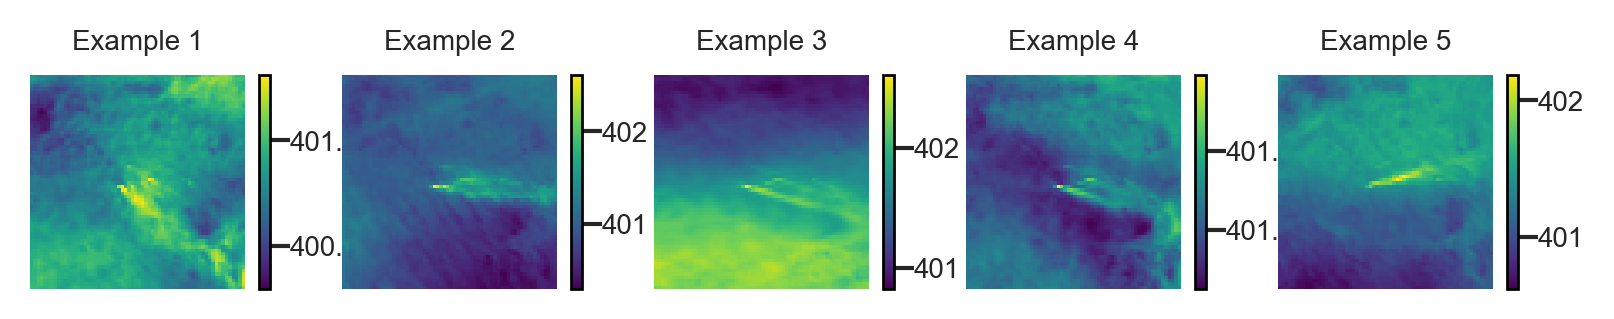

ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 2713227428681234.0
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 3544362003493666.0
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 4501195256171008.0
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 3250010829195084.0
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 6135548070298824.0


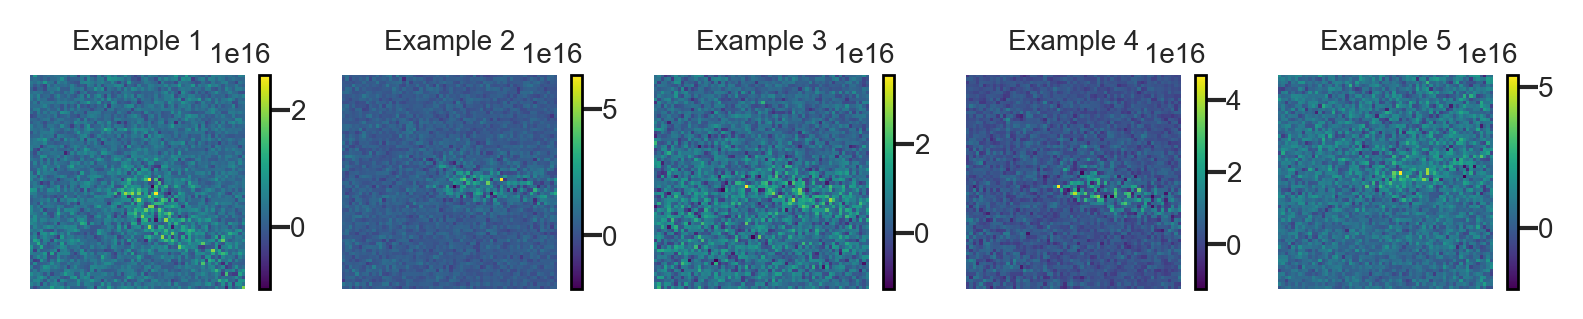

In [15]:
for i, idx in enumerate(example_indices):
    plot_data = inputs[idx, :, :, 0]

    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data, cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data == np.min(plot_data)))
    plt.colorbar(im, cax=cax)
    ic(np.min(plot_data))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

for i, idx in enumerate(example_indices):
    plot_data = inputs[idx, :, :, 2]

    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data, cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data == np.median(plot_data)))
    plt.colorbar(im, cax=cax)
    ic(np.median(plot_data))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

ic| np.sum(plot_data == np.min(plot_data)): 219
ic| np.min(plot_data): -4.5498257
ic| np.sum(plot_data == np.min(plot_data)): 1336
ic| np.min(plot_data): -4.5498257
ic| np.sum(plot_data == np.min(plot_data)): 1946
ic| np.min(plot_data): -4.5498257
ic| np.sum(plot_data == np.min(plot_data)): 1
ic| np.min(plot_data): -0.97250766
ic| np.sum(plot_data == np.min(plot_data)): 1794
ic| np.min(plot_data): -4.5498257


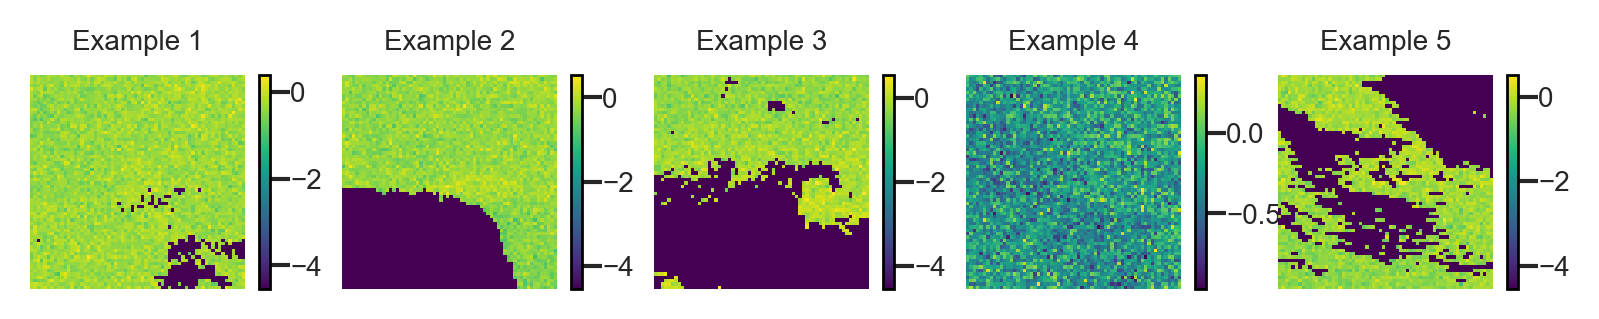

ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 0.0070366645
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): -0.084624976
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): -0.16769911
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 0.099983804
ic| np.sum(plot_data == np.median(plot_data)): 0
ic| np.median(plot_data): 0.23717856


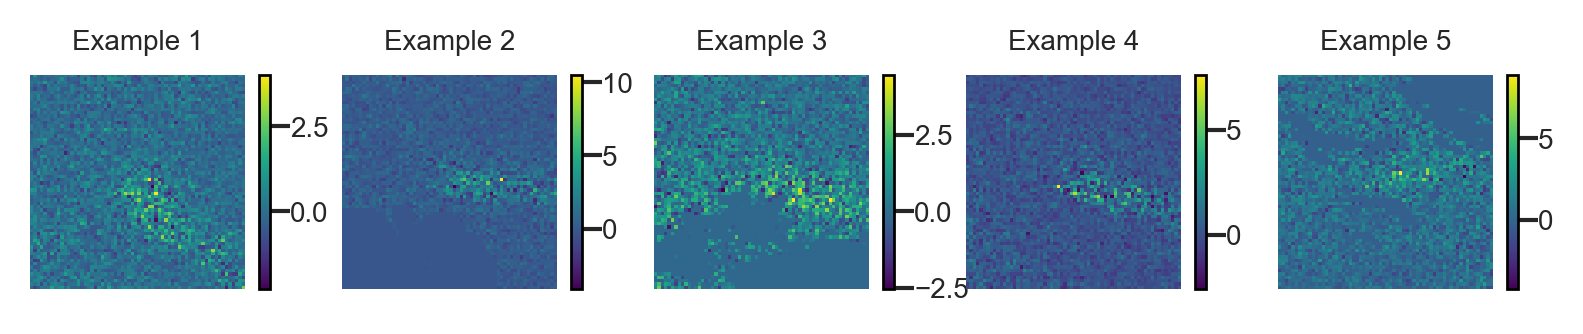

In [16]:
for i, idx in enumerate(example_indices):
    plot_data = outputs[idx, :, :, 0]

    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data, cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data == np.min(plot_data)))
    plt.colorbar(im, cax=cax)
    ic(np.min(plot_data))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

for i, idx in enumerate(example_indices):
    plot_data = outputs[idx, :, :, 2]

    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data, cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data == np.median(plot_data)))
    plt.colorbar(im, cax=cax)
    ic(np.median(plot_data))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

ic| np.sum(plot_data == np.min(plot_data)): 988
ic| np.median(plot_data): -0.34221786
ic| np.sum(plot_data == np.min(plot_data)): 1741
ic| np.median(plot_data): -0.41109684
ic| np.sum(plot_data == np.min(plot_data)): 2127
ic| np.median(plot_data): -0.5
ic| np.sum(plot_data == np.min(plot_data)): 510
ic| np.median(plot_data): -0.25688702
ic| np.sum(plot_data == np.min(plot_data)): 2037
ic| np.median(plot_data): -0.4934829


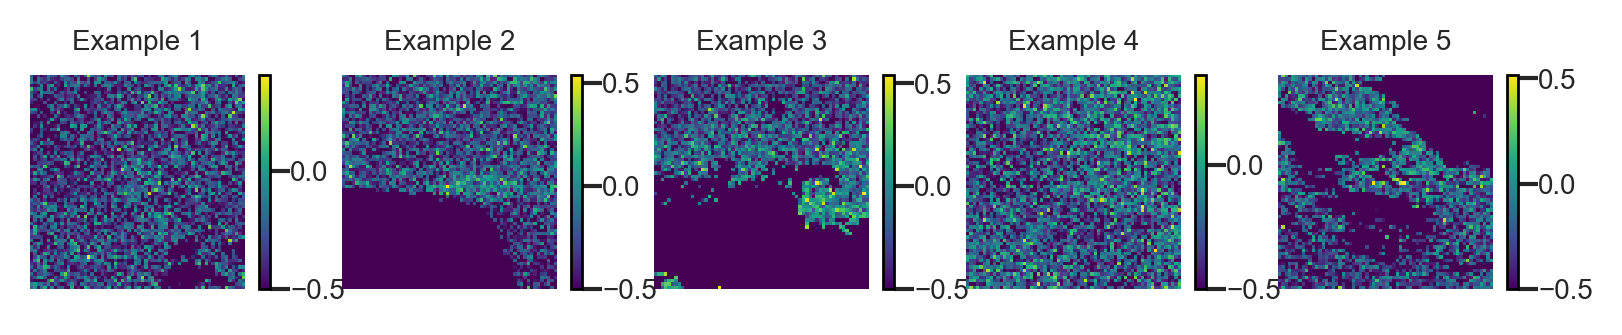

In [17]:
for i, idx in enumerate(example_indices):
    plot_data = outputs[idx, :, :, 0]
    plot_data = np.where(plot_data < -0.5, -0.5, plot_data)
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data, cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data == np.min(plot_data)))
    plt.colorbar(im, cax=cax)
    ic(np.median(plot_data))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()